# All Models and Training
## Import necessary libraries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [6]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [7]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [8]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load preprocessed data

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [10]:
if IN_COLAB:
    preprocessed_dir = 'drive/My Drive/Colab Data/'
    train_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    preprocessed_dir = '../data/preprocessed/'
    train_dir = '../data/train_data/'
    output_dir = '../data/result/'
    lmdict_dir = '../data/LoughranMcDonald/'
    glove_dir = '../data/GloVe'

In [1]:
# Load previously processed non-text data
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df


NameError: name 'train_dir' is not defined

In [12]:
# List of Non-text columns
nontext_columns = train_df.drop(columns=['target']).columns.tolist()
nontext_columns

['prev_decision',
 'GDP_diff_prev',
 'PMI_value',
 'Employ_diff_prev',
 'Rsales_diff_year',
 'Unemp_diff_prev',
 'Inertia_diff',
 'Hsales_diff_year',
 'Balanced_diff']

In [13]:
# Load text data
file = open(preprocessed_dir + 'text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open(preprocessed_dir + 'text_split_200.pickle', 'rb') # Split at 200 words
text_split_200 = pickle.load(file)
file.close()


file = open(preprocessed_dir + 'text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

## Check the statistics of texts

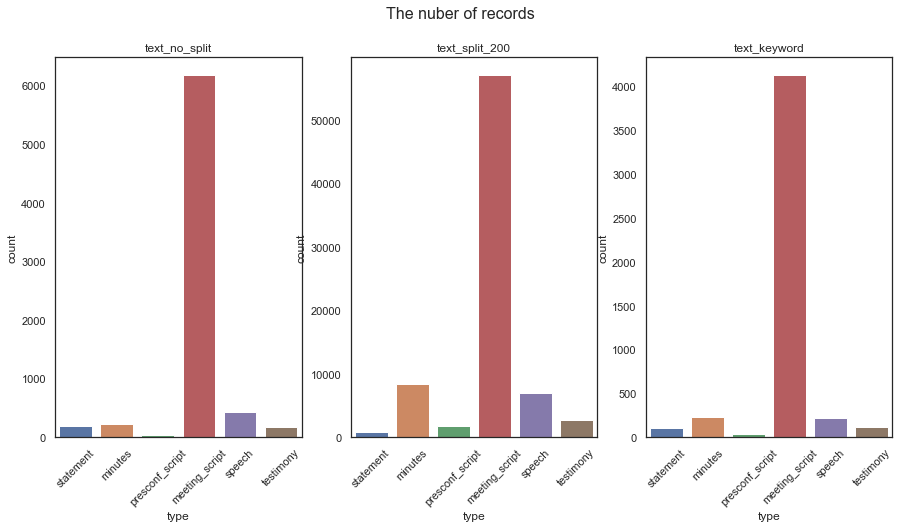

In [14]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()


In [15]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
467,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,903,0,8.25,1990-03-27,0,8.25,There's another thing that I suspect all...
468,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,1220,0,8.25,1990-03-27,0,8.25,And to the extent that the process migh...
469,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL,163,0,8.25,1990-03-27,0,8.25,"You can move to amend, that's right. Mr..."
470,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,681,0,8.25,1990-03-27,0,8.25,is right underneath thestaff's at 1-1/2 p...
471,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BERNARD,256,0,8.25,1990-03-27,0,8.25,I'm reading from line 59 of the draft d...


There are many meeting scripts but we do not use them this time as they cannot be used for prediction of the rate decision because meeting scripts are published four years after the meeting.

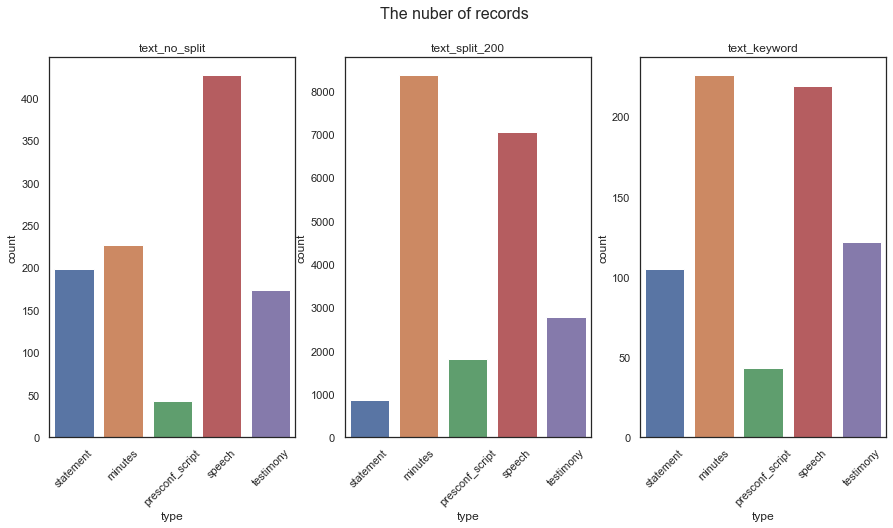

In [16]:
# Drop meeting script data
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

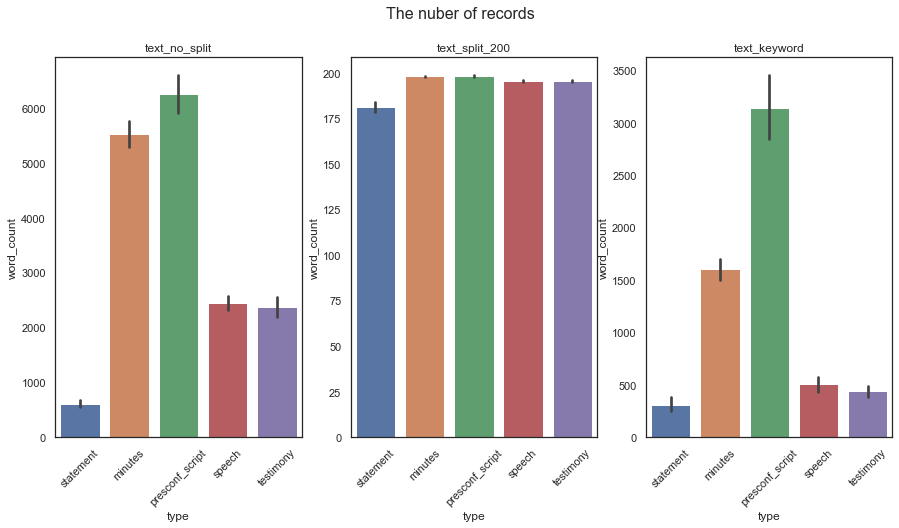

In [17]:
# Check the number of words per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.barplot(data=text_no_split, x='type', y='word_count', ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

### Select text dataframe

In [18]:
# Select one from the above different pre-processed data
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)
text_df

(1068, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,0,6.00,"In taking the discount action, the Board appro..."
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,Chairman Alan Greenspan announced today that t...
8,statement,1995-12-19,FOMC Statement,Alan Greenspan,81,-1,5.5,1996-01-31,-1,5.25,Chairman Alan Greenspan announced today that t...
9,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...


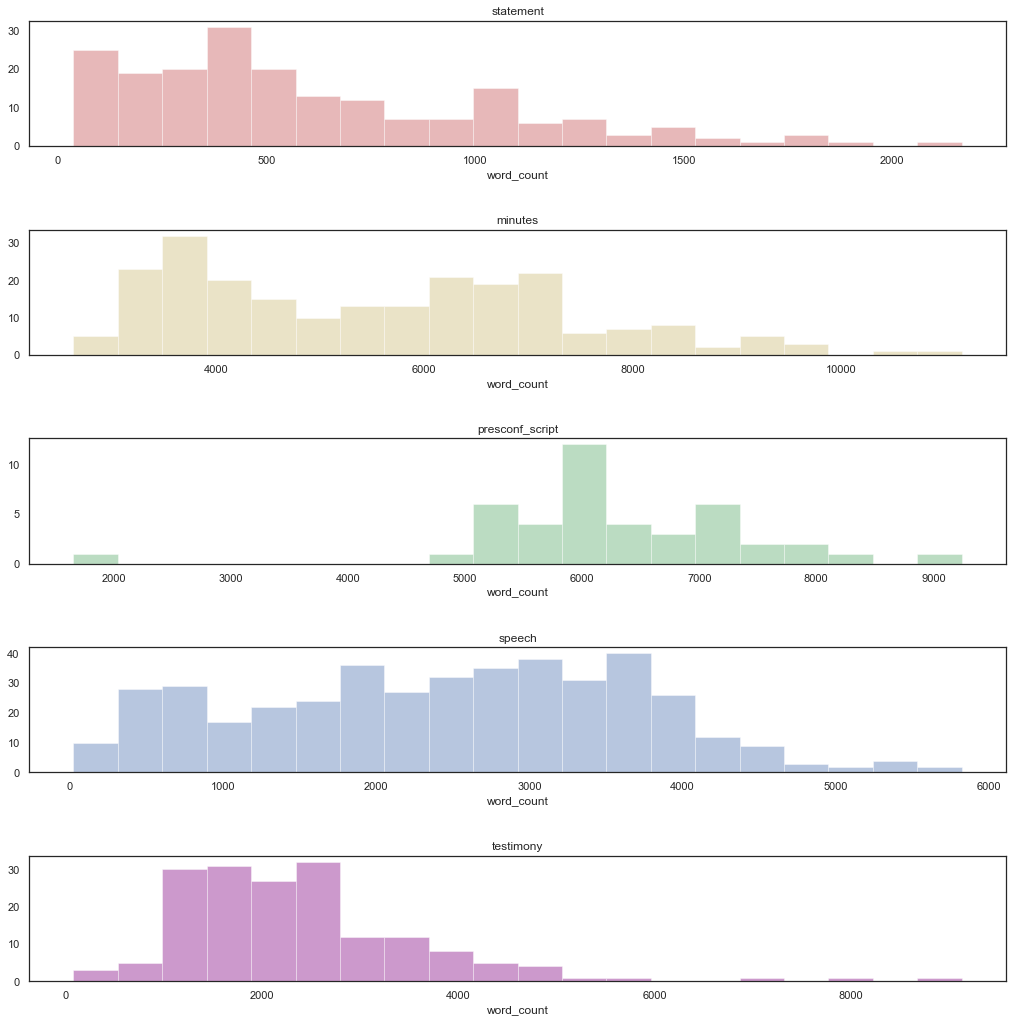

In [19]:
# Check distribution

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=False, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=False, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=False, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=False, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()

/Users/yuki/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


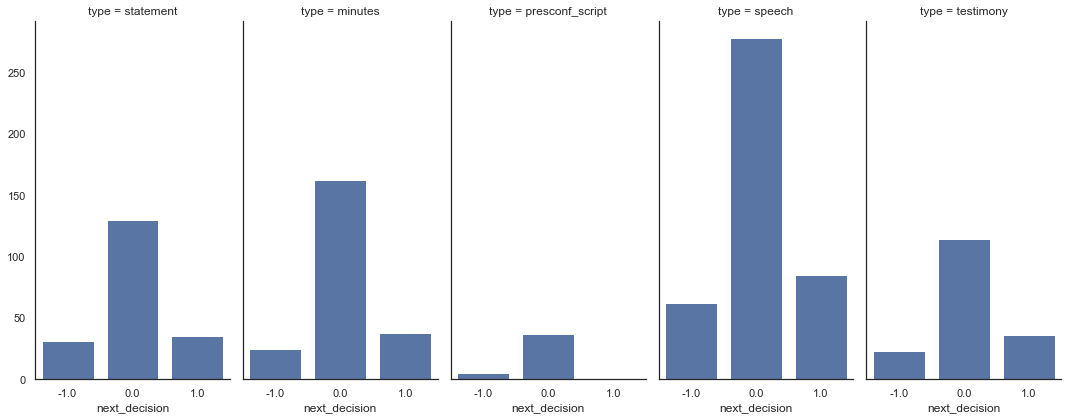

In [20]:
# Check balance of Rate Decision

g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


The label is highly biased to 0(Hold). Need to consider how to mitigate the biased data.

## Merge text to the train dataframe

In [21]:
from collections import defaultdict 

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)
    

In [22]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]

train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text
date,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,,,
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,,,
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,,,
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,
1983-01-28,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,
1983-02-09,0,0,0.039942,46.0,102.0,1.807631,0.000000,-0.091455,6.403612,0.003723,,,,,,
1983-03-29,1,0,0.039942,54.4,73.0,1.807631,0.133333,-0.104496,13.270610,0.003723,,,,,,
1983-04-29,0,1,0.039942,53.9,50.0,1.807631,0.166667,0.076200,20.486913,0.003723,,,,,,


In [23]:
# Check if most of docs are merged

count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count
    
    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

122473 words in original text for statement
121762 words in merged text for statement
1245796 words in original text for minutes
1238045 words in merged text for minutes
260217 words in original text for presconf_script
253982 words in merged text for presconf_script
1038969 words in original text for speech
1037401 words in merged text for speech
412334 words in original text for testimony
410549 words in merged text for testimony
Total: 3079789 words in original text
Total: 3061739 words in merged text
Total: 3061739 words in text column of merged text


Looks okay, but there are may rows without text as texts are only available from certain year.
It's not easy to fill those null values - for now drop those though the number of training data gets small...

In [24]:
print("Before dropping: ", train_df.shape)
train_df = train_df.loc[train_df['text'] != ""]
print("After dropping: ", train_df.shape)

Before dropping:  (398, 16)
After dropping:  (245, 16)


## Explore the text

In [25]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [26]:
corpus = create_corpus(text_df)

In [27]:
x, y = get_frequent_stop_words(corpus)

In [28]:
print(x)
print(y)

('the', 'of', 'in', 'to', 'and', 'a', 'that', 'for', 'on', 'as')
(211758, 115310, 96530, 91970, 89615, 48229, 46555, 32689, 23338, 22436)


In [29]:
x, y = get_frequent_nonstop_words(corpus)

In [30]:
print(x)
print(y)

('economic', 'financial', 'federal', 'inflation', 'market', 'would', 'rate', 'policy', 'growth', 'committee')
(14159, 13464, 13177, 12533, 11179, 10980, 10440, 9930, 9209, 8018)


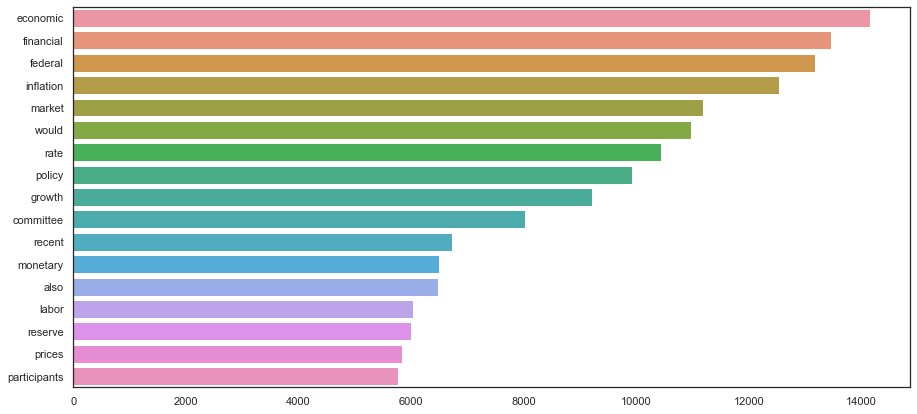

In [31]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

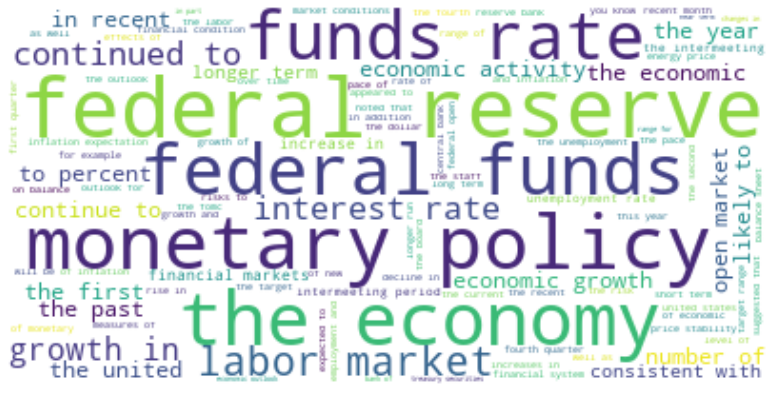

In [42]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [32]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
5,Negative,ABANDONS
6,Negative,ABDICATED
7,Negative,ABDICATES
8,Negative,ABDICATING
9,Negative,ABDICATION


In [33]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,184
Litigious,904
Negative,2355
Positive,354
StrongModal,19
Uncertainty,297
WeakModal,27


In [34]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [35]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [36]:
# Analyze tone for original text dataframe
print(text_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(text_df['text'], total=text_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
text_df = pd.concat([text_df, tone_lmdict_df.reindex(text_df.index)], axis=1)
text_df


(1068, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding]
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[]
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[]
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[]
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[]
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com...",-0.826446,121,1,2,[strength],"[against, persistent]"
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,0,6.00,"In taking the discount action, the Board appro...",0.000000,54,0,0,[],[]
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,Chairman Alan Greenspan announced today that t...,-2.985075,67,0,2,[],"[tightening, decline]"
8,statement,1995-12-19,FOMC Statement,Alan Greenspan,81,-1,5.5,1996-01-31,-1,5.25,Chairman Alan Greenspan announced today that t...,-2.469136,81,1,3,[favorable],"[easing, easing, decline]"
9,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...,0.000000,391,3,3,"[effective, effective, effective]","[easing, easing, easing]"


In [37]:
# Analyze tone for training dataframe
tone_lmdict_list = []
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type], 
                                                                                      total=train_df.shape[0], 
                                                                                      desc=doc_type)]
    tone_lmdict_list.append(tone_lmdict)
    
train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,,"By unanimous vote, Joan E. Lovett and Peter R...",,,,"By unanimous vote, Joan E. Lovett and Peter R...",-0.168253
1993-12-21,0,0,0.477315,53.8,268.0,4.732363,0.066667,0.018879,9.597330,-0.037480,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.078038
1994-02-04,1,0,1.360113,56.0,305.5,3.968305,0.066667,0.027275,11.608081,-0.077404,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.034575
1994-02-28,0,1,1.360113,56.0,305.5,3.968305,0.066667,0.047744,11.608081,-0.028708,Chairman Alan Greenspan announced today that ...,"By unanimous vote, the following officers of ...",,,,Chairman Alan Greenspan announced today that ...,-0.009599


In [38]:
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,,"By unanimous vote, Joan E. Lovett and Peter R...",,,,"By unanimous vote, Joan E. Lovett and Peter R...",-0.168253
1993-12-21,0,0,0.477315,53.8,268.0,4.732363,0.066667,0.018879,9.597330,-0.037480,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.078038
1994-02-04,1,0,1.360113,56.0,305.5,3.968305,0.066667,0.027275,11.608081,-0.077404,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.034575
1994-02-28,0,1,1.360113,56.0,305.5,3.968305,0.066667,0.047744,11.608081,-0.028708,Chairman Alan Greenspan announced today that ...,"By unanimous vote, the following officers of ...",,,,Chairman Alan Greenspan announced today that ...,-0.009599


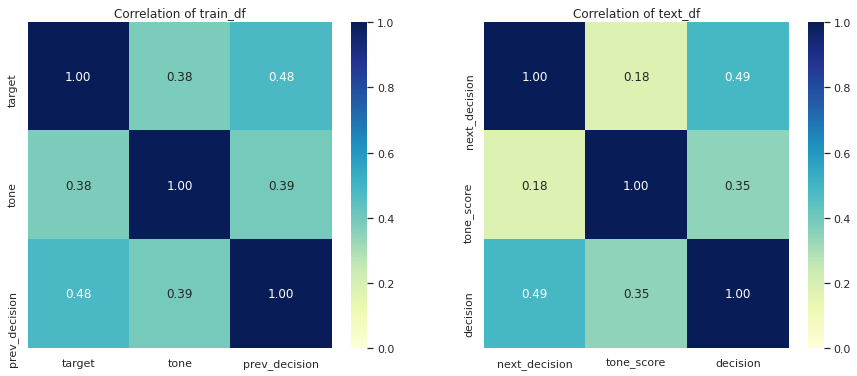

In [39]:
# Show corelations to next_decision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
corr_columns = ['target', 'tone', 'prev_decision']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation of train_df")
corr_columns = ['next_decision', 'tone_score', 'decision']
sns.heatmap(text_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
ax2.set_title("Correlation of text_df")
plt.show()

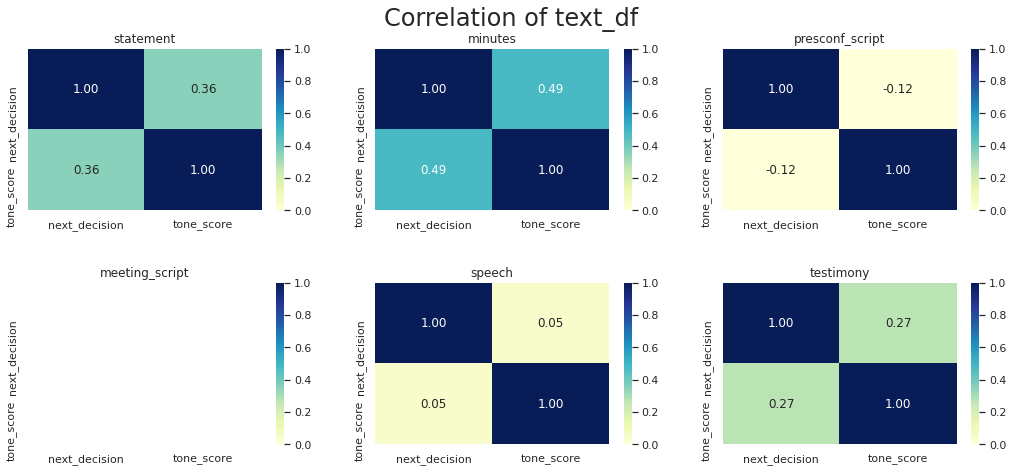

In [40]:
# Per document type
corr_columns = ['next_decision', 'tone_score', 'type']
doc_types = ['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
df = text_df[corr_columns]
for i, doc_type in enumerate(doc_types):
    sns.heatmap(df.loc[df['type'] == doc_type].drop(columns=['type']).astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(doc_type)

fig.suptitle('Correlation of text_df', fontsize=24)
fig.tight_layout(pad=3.0)
plt.show()

# Tokenize and vectorize

In [41]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized


## Tokenize text_df

In [42]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])


len(tokenized_org):  1068
['chairman', 'alan', 'greenspan', 'announce', 'today', 'federal', 'open', 'market', 'committee', 'decide', 'increase', 'slightly', 'degree', 'pressure', 'reserve', 'position', 'the', 'action', 'expect', 'associate', 'small', 'increase', 'money', 'market', 'interest', 'rate', 'the', 'decision', 'take', 'move', 'toward', 'le', 'accommodative', 'stance', 'monetary', 'policy', 'order', 'sustain', 'enhance', 'economic', 'expansion', 'chairman', 'greenspan', 'decide', 'announce', 'action', 'immediately', 'avoid', 'misunderstand', 'committee', 'purpose', 'give', 'fact', 'first', 'firm', 'reserve', 'market', 'condition', 'committee', 'since', 'early']


In [43]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  1068
chairman alan greenspan announce today federal open market committee decide increase slightly degree pressure reserve position the action expect associate small increase money market interest rate the decision take move toward le accommodative stance monetary policy order sustain enhance economic expansion chairman greenspan decide announce action immediately avoid misunderstand committee purpose give fact first firm reserve market condition committee since early


In [44]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

len(all_words_org):  1816700
chairman
len(counts_org):  20411
bow_org[:20] ['market', 'rate', 'the', 'inflation', 'economic', 'financial', 'price', 'policy', 'federal', 'bank', 'committee', 'growth', 'increase', 'would', 'year', 'in', 'continue', 'economy', 'reserve', 'i']
vocab_org['chairman']:  1
vocab_org['market']:  8


In [45]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

1068


In [46]:
# Add to the dataframe
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

In [47]:
# # Filter by frequency of words
# # This time, switch it off as the frequency is already considered while creating the vocabrary

# freq = {}
# num_words = len(all_words)
# print('len(all_words): ', len(all_words))

# for key in counts:
#     freq[key] = counts[key]/num_words

# print('len(freq): ', len(freq))
# print(freq['rate'])

# low_cutoff = 0.000001
# high_cutoff = 20

# K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])

# filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
# print(K_most_common)
# print('len(filtered_words): ', len(filtered_words))

## Tokenize train_df

In [48]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids
train_df['tokenized_text'] = train_df['tokenized'].apply(lambda x: " ".join(x))


len(tokenized):  245
['the', 'secretary', 'report', 'advice', 'election', 'reserve', 'bank', 'member', 'alternate', 'member', 'federal', 'open', 'market', 'committee', 'period', 'commence', 'january', 'end', 'december', 'receive', 'individual', 'execute', 'oath', 'office', 'the', 'elect', 'member', 'alternate', 'member', 'follow', 'by', 'unanimous', 'vote', 'committee', 'elect', 'follow', 'officer', 'federal', 'open', 'market', 'committee', 'serve', 'election', 'successor', 'first', 'meet', 'committee', 'december', 'understand', 'event', 'discontinuance', 'official', 'connection', 'board', 'governor', 'federal', 'reserve', 'bank', 'would', 'cease', 'official', 'connection', 'federal', 'open', 'market', 'committee', 'by', 'unanimous', 'vote', 'william', 'mcdonough', 'margaret', 'greene', 'joan', 'lovett', 'select', 'serve', 'pleasure', 'committee', 'capacity', 'manager', 'system', 'open', 'market', 'account', 'deputy', 'manager', 'foreign', 'operation', 'system', 'open', 'market', 'acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

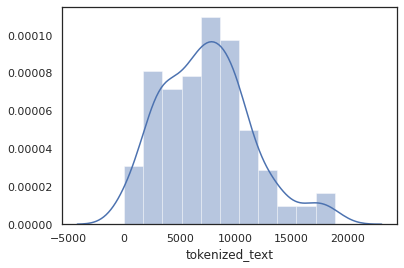

In [49]:
sns.distplot(train_df['tokenized_text'].apply(lambda x: len(x.split())))

In [50]:
len(token_ids[0])

4809

## Lemmatize sentiment

In [51]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [52]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,145
Litigious,750
Negative,2355
Positive,354
StrongModal,15
Uncertainty,257


## Tfidf 

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

### Text dataframe

In [54]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

1068
2355


In [55]:
text_df.shape

(1068, 19)

In [56]:
for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
text_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words,tokenized,token_ids,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 15, 11, 12, 13, 14, 15, 16,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[],"[in, take, discount, action, board, approve, r...","[51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 58, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[],"[in, take, discount, rate, action, board, appr...","[51, 26, 52, 24, 18, 53, 54, 55, 56, 53, 57, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com...",-0.826446,121,1,2,[strength],"[against, persistent]","[in, relate, move, federal, open, market, comm...","[51, 79, 27, 6, 7, 8, 9, 10, 11, 52, 24, 80, 8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,0,6.00,"In taking the discount action, the Board appro...",0.000000,54,0,0,[],[],"[in, take, discount, action, board, approve, r...","[51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 6,

### Train dataframe

In [57]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf['Negative']))
print(len(sentiment_tfidf['Negative'][0]))

for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
    
train_df

245
2355


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining
date,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711,"[the, secretary, report, advice, election, res...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...",the secretary report advice election reserve b...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.034224750271236525, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.06271366751762956, 0.18..."
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716,"[at, start, meet, subcommittee, establish, rev...","[95, 485, 33, 348, 270, 334, 154, 357, 1127, 1...",at start meet subcommittee establish review po...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8597560819308422, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07481243047159189,..."
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 372, 274, 154, 373...",the committee turn discussion economic outlook...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.10530925287224485,..."
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 368, 369, 370, 371...",the committee turn discussion economic outlook...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.150...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.655408558906601, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.07537767788891227, 0.0,..."
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616,"[secretary, note, advice, receive, election, w...","[2, 783, 4, 19, 5, 43, 44, 39, 1640, 10, 6, 7,...",secretary note advice receive election william...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5801130206166596, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07553466760642374,..."
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,,"By unanimous vote, Joan E. Lovett and Peter R...",,,,"By unanimous vote, Joan E. Lovett and Peter R...",-0.168253,"[by, unanimous, vote, joan, lovett, peter, fis...","[26, 27, 28, 47, 48, 1730, 1731, 49, 30, 50, 1...",by unanimous vote joan love

## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [59]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

244


In [60]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
train_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining,cos_sim_Negative,cos_sim_Positive,cos_sim_Uncertainty,cos_sim_Litigious,cos_sim_StrongModal,cos_sim_Constraining
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711,"[the, secretary, report, advice, election, res...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...",the secretary report advice election reserve b...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.034224750271236525, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.06271366751762956, 0.18...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716,"[at, start, meet, subcommittee, establish, rev...","[95, 485, 33, 348, 270, 334, 154, 357, 1127, 1...",at start meet subcommittee establish review po...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8597560819308422, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07481243047159189,...",0.639645,0.862652,0.712663,0.116021,0.000000,0.913327
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 372, 274, 154, 373...",the committee turn discussion economic outlook...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.10530925287224485,...",0.646613,0.899890,0.877962,0.712396,0.000000,0.957226
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 368, 369, 370, 371...",the committee turn discussion economic outlook...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.150...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.655408558906601, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.07537767788891227, 0.0,...",0.617205,0.802198,0.691030,0.872348,0.655409,0.949805
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616,"[secretary, note, advice, receive, election, w...","[2, 783, 4, 19, 5, 43, 44, 39, 1640, 10, 6, 7,...",secretary note advice receive election william...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5801130206166596, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0755346676064237

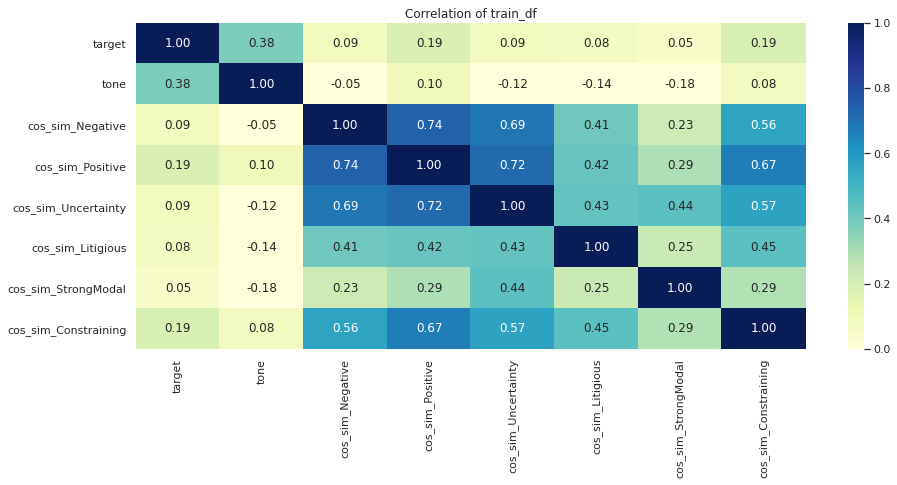

In [61]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

### Convert target class for classification

In [62]:
def convert_class(x):
    if x == 1:
        return 2
    elif x == 0:
        return 1
    elif x == -1:
        return 0

In [63]:
train_df['target'] = train_df['target'].map(convert_class)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
train_df['prev_decision'] = train_df['prev_decision'].map(convert_class)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Modeling and Training
## Common Functions

In [65]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
kfold

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [66]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [67]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


## A. Cosin Similarity
### Train and Test Data

In [68]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [69]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 
                                     'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

### Train

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.7s finished
[2020-06-23 06:20:01,468][INFO] ## Training - acc: 0.99489796, f1: 0.99293105
[2020-06-23 06:20:01,475][INFO] ## Test - acc: 0.77551020, f1: 0.67057903


Best Score:  0.5641765109319751
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}


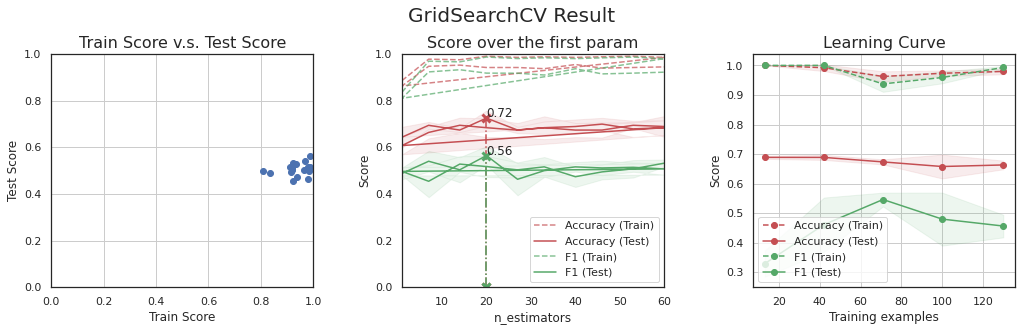

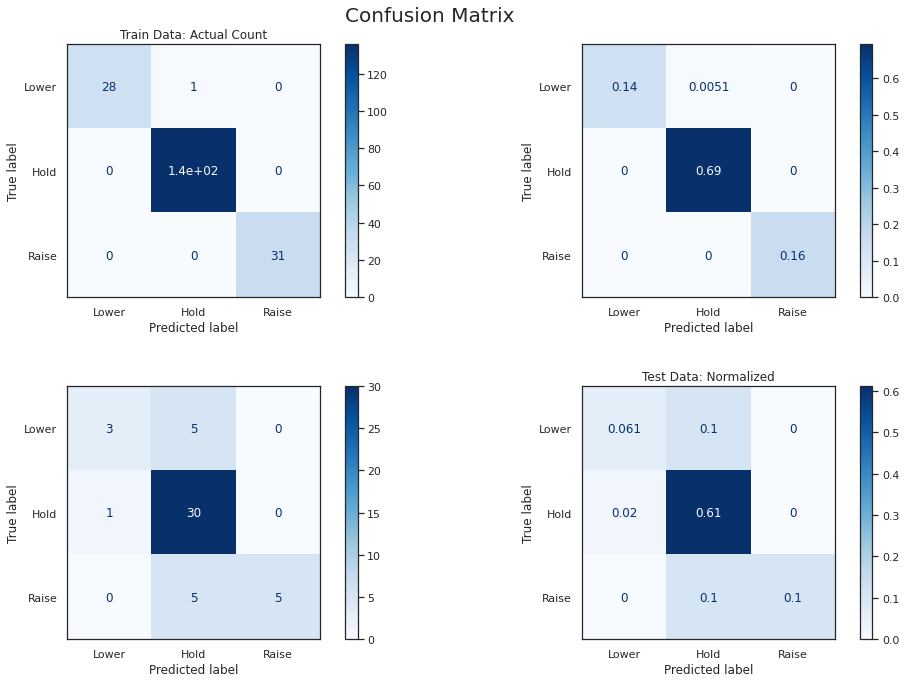

In [70]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

Text(0.5, 1.0, 'Feature importance')

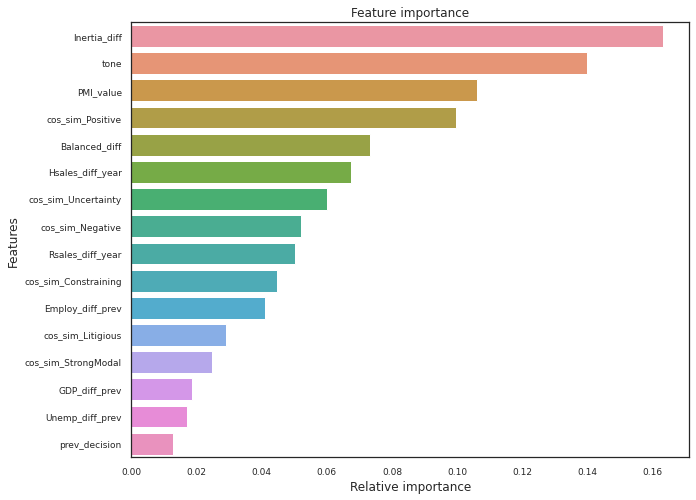

In [71]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


## B. Tfidf
Use Tfidf instead of cosin similarity
### Train and Test Data

In [72]:
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone,tokenized,token_ids,tokenized_text,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining,cos_sim_Negative,cos_sim_Positive,cos_sim_Uncertainty,cos_sim_Litigious,cos_sim_StrongModal,cos_sim_Constraining
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-02-18,1,1,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711,"[the, secretary, report, advice, election, res...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...",the secretary report advice election reserve b...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.034224750271236525, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.06271366751762956, 0.18...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-05-18,1,1,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716,"[at, start, meet, subcommittee, establish, rev...","[95, 485, 33, 348, 270, 334, 154, 357, 1127, 1...",at start meet subcommittee establish review po...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8597560819308422, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07481243047159189,...",0.639645,0.862652,0.712663,0.116021,0.000000,0.913327
1993-07-07,1,1,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 372, 274, 154, 373...",the committee turn discussion economic outlook...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.10530925287224485,...",0.646613,0.899890,0.877962,0.712396,0.000000,0.957226
1993-08-17,1,1,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 368, 369, 370, 371...",the committee turn discussion economic outlook...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.150...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.655408558906601, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.07537767788891227, 0.0,...",0.617205,0.802198,0.691030,0.872348,0.655409,0.949805
1993-09-21,1,1,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616,"[secretary, note, advice, receive, election, w...","[2, 783, 4, 19, 5, 43, 44, 39, 1640, 10, 6, 7,...",secretary note advice receive election william...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5801130206166596, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0755346676064237

In [73]:
vocabulary=sentiment_dict['Negative']+sentiment_dict['Positive']

In [74]:
# X and Y data used
Y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'tokenized_text']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

In [75]:
import scipy
def get_numeric_data(x):
    return [record[:-2].astype(float) for record in x]

def get_text_data(x):
    return [record[-1] for record in x]

from sklearn.preprocessing import FunctionTransformer
transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)

clf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word', vocabulary=vocabulary))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.5min finished


Best Score:  0.3545391717636963
Best Param:  {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 7, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 3, 'clf__n_estimators': 1}


[2020-06-23 06:21:39,960][INFO] ## Training - acc: 0.70408163, f1: 0.53361759
[2020-06-23 06:21:39,963][INFO] ## Test - acc: 0.67346939, f1: 0.32727273


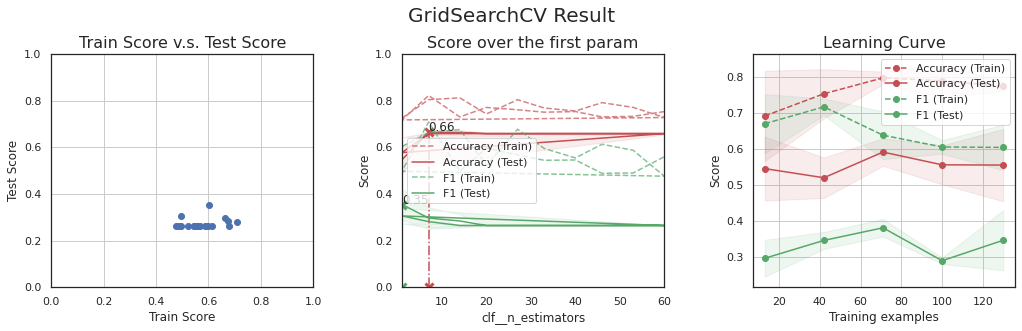

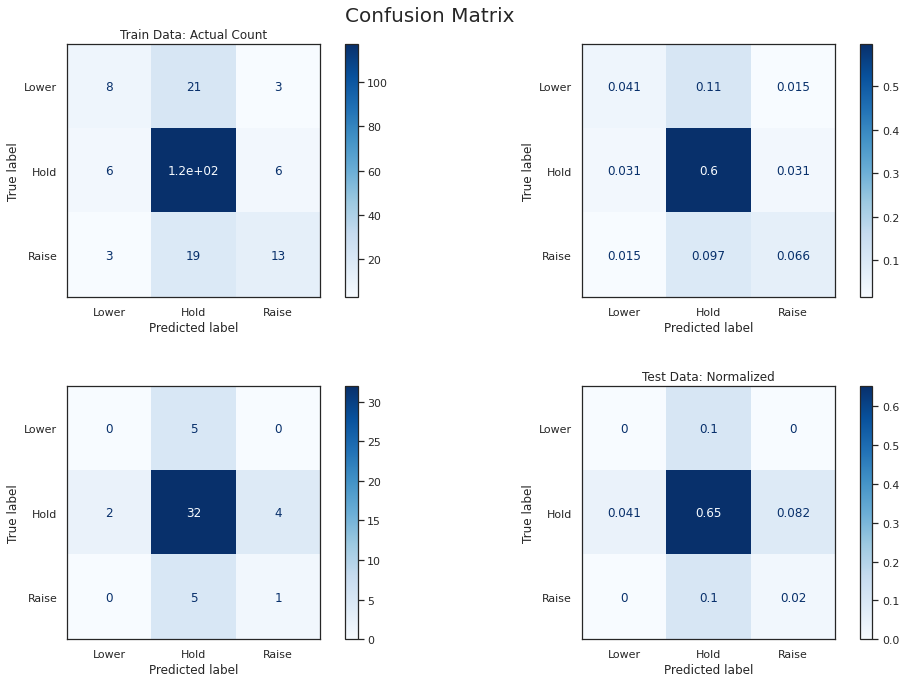

In [76]:
pipeline = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', transfomer_numeric)
            ])),
             ('text_features', Pipeline([
                ('selector', transformer_text),
                ('vec', TfidfVectorizer(analyzer='word'))
            ]))
         ])),
    ('clf', RandomForestClassifier())
])

# Perform Grid Search
param_grid = {'clf__n_estimators': np.linspace(1, 60, 10, dtype=int),
              'clf__min_samples_split': [3, 10],
              'clf__min_samples_leaf': [3],
              'clf__max_features': [7],
              'clf__max_depth': [None],
              'clf__criterion': ['gini'],
              'clf__bootstrap': [False]}

rf_model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_



## C. LSTM (RNN)
Instead of Tfidf, use LSTM. Concatinate the lstm output and the meta data at the end and dense layer to fully connect them.

### Input Data

In [77]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_df['target']
X_data = train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 196
Shape of train text 196
Shape of valid meta  49
Shape of valid text  49
Meta data size:  9


### Model
#### Embed -> RNN -> Dense -> Softmax

In [78]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [79]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [80]:
def dataloader(messages, meta, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        meta = [meta[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # print(len(tokens))
            # print(len(tokens[0]))
            # print(token_tensor.shape)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            # print(token_tensor[:sequence_length].shape)
            # print(start_idx, batch_num)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        meta_tensor = torch.tensor(meta[ii: ii+len(batch_messages)])
        
        yield batch, meta_tensor, label_tensor

In [81]:
# Test
text_batch, meta_batch, labels = next(iter(dataloader(X_train_text, X_train_meta, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, meta_size, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, meta_batch, hidden)
print(logps)

tensor([[-8.1881e+01,  0.0000e+00, -2.9903e+01],
        [ 0.0000e+00, -1.6908e+02, -5.7992e+01],
        [-8.6356e+01,  0.0000e+00, -3.3253e+01],
        [-1.2752e+02,  0.0000e+00, -5.8550e+01],
        [-1.2259e+02,  0.0000e+00, -5.5294e+01],
        [-4.1249e+01, -1.0803e-02, -4.5333e+00],
        [-1.8227e+01, -1.2216e+01, -5.0068e-06],
        [-1.0678e+02,  0.0000e+00, -4.7269e+01],
        [-7.5158e+01,  0.0000e+00, -2.7868e+01],
        [-9.4354e+01,  0.0000e+00, -4.0909e+01],
        [-1.7285e-05, -6.7386e+01, -1.0963e+01],
        [-6.1694e+01,  0.0000e+00, -2.1966e+01],
        [-2.1644e+01, -1.0684e+01, -2.2888e-05],
        [-1.2979e+02,  0.0000e+00, -5.8329e+01],
        [-7.5904e+00, -3.3926e+01, -5.0544e-04],
        [-1.0246e+02,  0.0000e+00, -4.4822e+01]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Configure the model and train!

In [82]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(20391, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

In [83]:
def train_model(model, epochs=3, batch_size=8, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, meta_batch, labels in dataloader(
                X_train_text, X_train_meta, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, meta_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, meta_batch, labels in dataloader(
                        X_valid_text, X_valid_meta, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, meta_batch, labels = text_batch.to(device), meta_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, meta_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Lower', 'Hold', 'Raise']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 47.568188... Val Loss: 39.587787 Accuracy: 0.541667 F1 Score: 0.237443
Epoch: 1/3... Step: 20... Loss: 23.992870... Val Loss: 39.382629 Accuracy: 0.541667 F1 Score: 0.237443
25 steps in epoch 1

Epoch: 1, Average Accuracy: 0.54166667, Average f1: 0.23744292



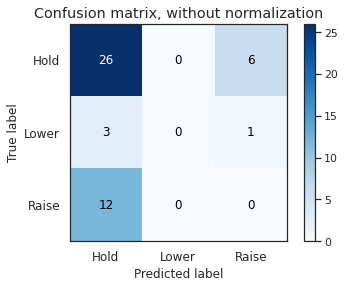

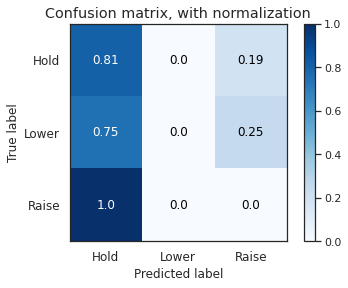

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 47.013073... Val Loss: 39.110950 Accuracy: 0.541667 F1 Score: 0.237443
Epoch: 2/3... Step: 20... Loss: 23.683365... Val Loss: 38.909769 Accuracy: 0.541667 F1 Score: 0.237443
25 steps in epoch 2

Epoch: 2, Average Accuracy: 0.54166667, Average f1: 0.23744292



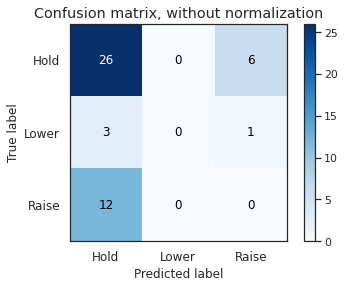

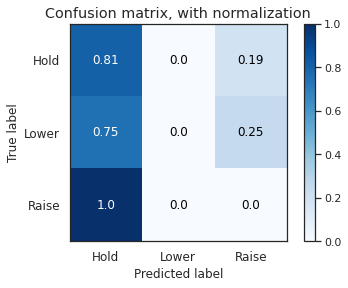

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 46.460297... Val Loss: 38.638453 Accuracy: 0.541667 F1 Score: 0.237443
Epoch: 3/3... Step: 20... Loss: 23.375008... Val Loss: 38.437118 Accuracy: 0.541667 F1 Score: 0.237443
25 steps in epoch 3

Epoch: 3, Average Accuracy: 0.54166667, Average f1: 0.23744292



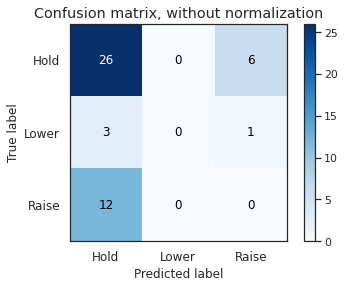

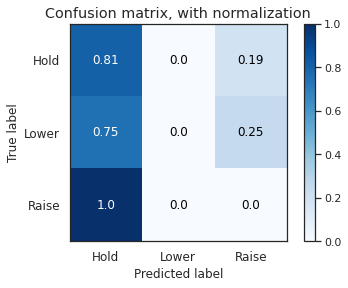

In [84]:
train_model(model)

## D. Glove Word Embedding + LSTM
Use GloVe word embedding instead of Tfidf

### Download GloVe files

In [85]:
# Use 6B 300d
glove_file = 'glove.6B.300d.pickle'
glove_path = glove_dir + glove_file
    
# Download Glove file if not exist
if not os.path.exists(glove_path):
    if not os.path.exists(glove_path):
        os.mkdir(glove_path)
    !wget -o ${glove_dir} http://nlp.stanford.edu/data/glove.6B.zip
    !unzip ${glove_dir}glove*.zip

    embedding_dict = {}

    with open(glove_dir + "glove.6B.300d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_path, 'wb'))

In [86]:
glove_dict = pickle.load(open(glove_path, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [87]:
weight_matrix = np.zeros((len(vocab), 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

11688 words found out of 20390 words in vocab.
(20390, 300)


In [88]:
type(weight_matrix)

numpy.ndarray

In [89]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, dense_size, meta_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, nn_input_meta, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(concat_layer)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [90]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(20390, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 6.590707... Val Loss: 11.865845 Accuracy: 0.270833 F1 Score: 0.211549
Epoch: 1/3... Step: 20... Loss: 13.445548... Val Loss: 11.595055 Accuracy: 0.270833 F1 Score: 0.211549
25 steps in epoch 1

Epoch: 1, Average Accuracy: 0.27083333, Average f1: 0.21154946



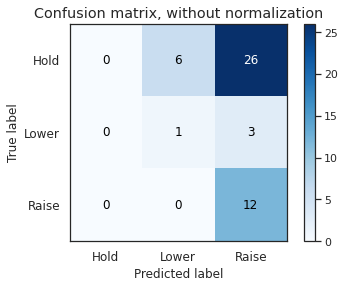

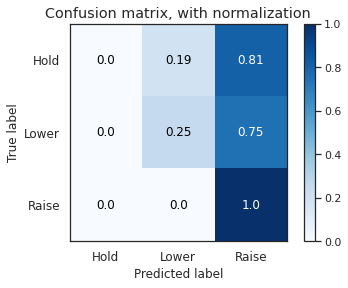

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 6.124574... Val Loss: 11.198897 Accuracy: 0.270833 F1 Score: 0.211549
Epoch: 2/3... Step: 20... Loss: 12.593500... Val Loss: 10.914658 Accuracy: 0.250000 F1 Score: 0.201632
25 steps in epoch 2

Epoch: 2, Average Accuracy: 0.25000000, Average f1: 0.20163170



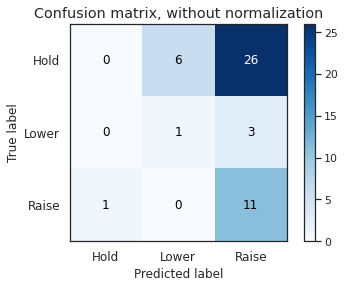

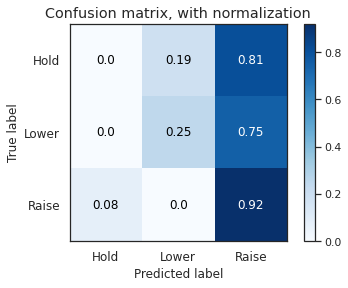

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 5.578933... Val Loss: 10.451470 Accuracy: 0.312500 F1 Score: 0.267438
Epoch: 3/3... Step: 20... Loss: 11.342730... Val Loss: 10.018644 Accuracy: 0.312500 F1 Score: 0.267438
25 steps in epoch 3

Epoch: 3, Average Accuracy: 0.31250000, Average f1: 0.26743789



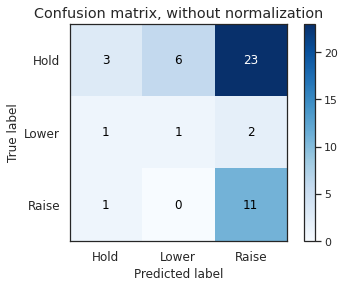

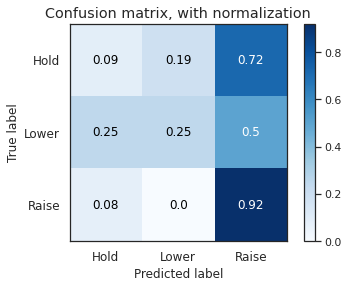

In [91]:
train_model(model)

The result does not look good. In fact, only the first hunderds of text can be used. Now, consider to split the text to the length of 200 with overlapping 50 words again.

In [92]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'],
      dtype='object')

In [93]:
split_train_df = train_df.drop(columns=['statement',
       'minutes', 'presconf_script', 'speech', 'testimony',
       'tokenized', 'token_ids', 'tokenized_text', 'tfidf_Negative',
       'tfidf_Positive', 'tfidf_Uncertainty', 'tfidf_Litigious',
       'tfidf_StrongModal', 'tfidf_Constraining', 'cos_sim_Negative',
       'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious',
       'cos_sim_StrongModal', 'cos_sim_Constraining'])

In [94]:
split_train_df.shape

(245, 12)

In [95]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            #row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)

    return split_df

In [96]:
split_train_df = get_split_df(split_train_df)
split_train_df.shape

(20605, 12)

In [97]:
tokenized = tokenize_df(split_train_df)
lemma_docs = [" ".join(words) for words in tokenized]
all_words = [word for text in tokenized for word in text]
counts = Counter(all_words)
bow = sorted(counts, key=counts.get, reverse=True)
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

# Add to the dataframe
split_train_df['token_ids'] = token_ids


In [98]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))
        

In [99]:
split_train_df.head()

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,text,tone,token_ids
0,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,The Secretary reported that advices of the ele...,-0.146711,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,..."
1,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,Manager of the System Open Market Account Depu...,-0.146711,"[55, 56, 11, 12, 57, 58, 55, 59, 60, 56, 11, 1..."
2,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,the System Open Market Account that were conta...,-0.146711,"[56, 11, 12, 57, 103, 25, 77, 104, 105, 56, 11..."
3,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,allow them to mature without replacement provi...,-0.146711,"[144, 142, 145, 146, 147, 148, 149, 118, 119, ..."
4,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,to nine months at the time of acceptance that ...,-0.146711,"[175, 176, 177, 169, 178, 179, 180, 181, 182, ..."


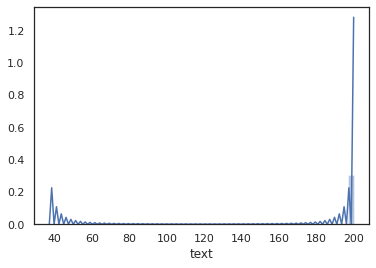

In [100]:
sns.distplot(split_train_df['text'].apply(lambda x: len(x.split())))

In [101]:
# X and Y data used
y_data = split_train_df['target']
X_data = split_train_df[nontext_columns + ['tone', 'token_ids']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data.values, y_data.values, test_size=0.2, shuffle=True)

X_train_meta = get_numeric_data(X_train)
X_train_text = get_text_data(X_train)
X_valid_meta = get_numeric_data(X_valid)
X_valid_text = get_text_data(X_valid)

print('Shape of train meta', len(X_train_meta))
print('Shape of train text', len(X_train_text))
print("Shape of valid meta ", len(X_valid_meta))
print("Shape of valid text ", len(X_valid_text))

meta_size = len(X_train_meta[0])
print("Meta data size: ", meta_size)

Shape of train meta 16484
Shape of train text 16484
Shape of valid meta  4121
Shape of valid text  4121
Meta data size:  9


In [102]:
len(weight_matrix)

20848

In [103]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 8, meta_size, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(20848, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=17, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 30.117195... Val Loss: 40.036180 Accuracy: 0.269942 F1 Score: 0.265007
Epoch: 1/3... Step: 20... Loss: 40.290440... Val Loss: 39.708398 Accuracy: 0.269942 F1 Score: 0.265007
Epoch: 1/3... Step: 30... Loss: 47.279499... Val Loss: 39.374302 Accuracy: 0.269942 F1 Score: 0.265007
Epoch: 1/3... Step: 40... Loss: 43.333202... Val Loss: 39.025263 Accuracy: 0.269942 F1 Score: 0.265007
Epoch: 1/3... Step: 50... Loss: 39.190231... Val Loss: 38.650910 Accuracy: 0.269455 F1 Score: 0.264216
Epoch: 1/3... Step: 60... Loss: 38.207588... Val Loss: 38.175717 Accuracy: 0.268239 F1 Score: 0.262240
Epoch: 1/3... Step: 70... Loss: 26.605295... Val Loss: 37.486453 Accuracy: 0.280885 F1 Score: 0.273735
Epoch: 1/3... Step: 80... Loss: 36.116703... Val Loss: 36.796284 Accuracy: 0.277237 F1 Score: 0.266230
Epoch: 1/3... Step: 90... Loss: 24.006594... Val Loss: 36.184520 Accuracy: 0.272860 F1 Score: 0.258292
Epoch: 1/3... Step: 100... Loss: 35.630169... Val Loss: 

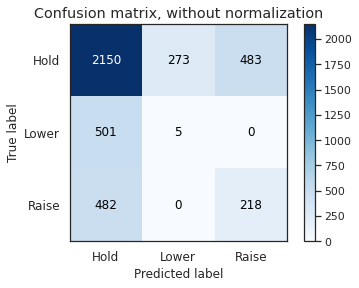

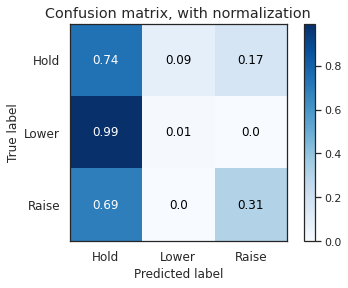

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 1.592064... Val Loss: 1.759179 Accuracy: 0.579523 F1 Score: 0.354755
Epoch: 2/3... Step: 20... Loss: 2.624507... Val Loss: 1.741940 Accuracy: 0.608220 F1 Score: 0.401239
Epoch: 2/3... Step: 30... Loss: 1.787747... Val Loss: 1.704630 Accuracy: 0.601411 F1 Score: 0.390772
Epoch: 2/3... Step: 40... Loss: 1.871551... Val Loss: 1.669226 Accuracy: 0.601411 F1 Score: 0.390772
Epoch: 2/3... Step: 50... Loss: 1.436158... Val Loss: 1.631798 Accuracy: 0.603356 F1 Score: 0.420215
Epoch: 2/3... Step: 60... Loss: 1.639111... Val Loss: 1.602489 Accuracy: 0.602870 F1 Score: 0.432694
Epoch: 2/3... Step: 70... Loss: 0.935105... Val Loss: 1.556192 Accuracy: 0.587062 F1 Score: 0.400129
Epoch: 2/3... Step: 80... Loss: 2.020096... Val Loss: 1.523043 Accuracy: 0.578794 F1 Score: 0.396005
Epoch: 2/3... Step: 90... Loss: 0.587484... Val Loss: 1.501362 Accuracy: 0.578794 F1 Score: 0.391818
Epoch: 2/3... Step: 100... Loss: 1.588047... Val Loss: 1.486049 Accuracy: 

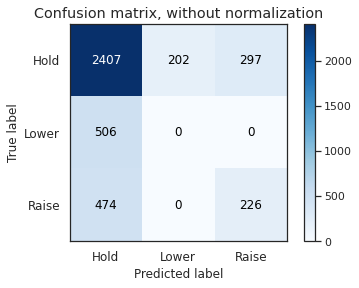

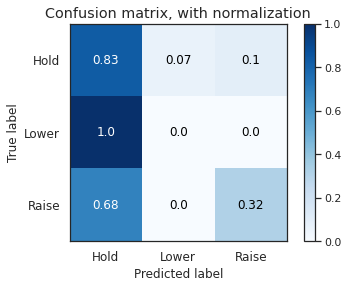

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 0.904462... Val Loss: 0.946924 Accuracy: 0.644455 F1 Score: 0.388932
Epoch: 3/3... Step: 20... Loss: 1.616617... Val Loss: 0.946716 Accuracy: 0.636673 F1 Score: 0.388116
Epoch: 3/3... Step: 30... Loss: 0.786336... Val Loss: 0.935825 Accuracy: 0.650535 F1 Score: 0.360127
Epoch: 3/3... Step: 40... Loss: 0.900688... Val Loss: 0.934497 Accuracy: 0.655885 F1 Score: 0.349367
Epoch: 3/3... Step: 50... Loss: 0.843081... Val Loss: 0.934284 Accuracy: 0.643969 F1 Score: 0.364605
Epoch: 3/3... Step: 60... Loss: 1.043818... Val Loss: 0.934106 Accuracy: 0.651021 F1 Score: 0.359248
Epoch: 3/3... Step: 70... Loss: 1.049427... Val Loss: 0.936451 Accuracy: 0.653696 F1 Score: 0.322198
Epoch: 3/3... Step: 80... Loss: 1.252271... Val Loss: 0.937347 Accuracy: 0.648589 F1 Score: 0.305440
Epoch: 3/3... Step: 90... Loss: 0.537463... Val Loss: 0.928600 Accuracy: 0.658804 F1 Score: 0.357197
Epoch: 3/3... Step: 100... Loss: 0.964869... Val Loss: 0.933725 Accuracy: 

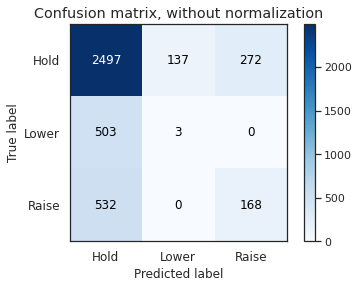

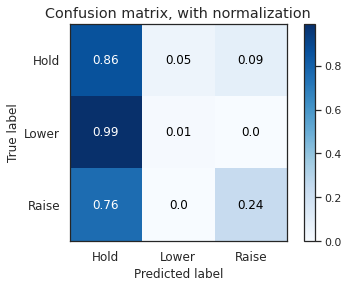

In [104]:
train_model(model, epochs=3, batch_size=16, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10)

## E. BERT Model

In [105]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
#import torch


In [106]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, meta, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments,
            'meta': meta
        }
        self.label = label

In [107]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=200):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

In [108]:
# Prepare training data
train_set = []
max_seq_length = 200
meta_size = 10

for index, row in tqdm(split_train_df.iterrows(), total=split_train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['text'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, row[nontext_columns + ['tone']], int(row['target'])))    

train_labels = split_train_df['target'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_meta =np.array([data.features['meta'] for data in train_set], dtype=np.float64)
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(split_train_df), 3), dtype=np.float32)

In [109]:
print(train_valid_meta[0])
print(train_valid_meta[1])

[ 1.00000000e+00  1.04316469e+00  5.58000000e+01  2.61000000e+02
  1.80763085e+00  0.00000000e+00 -1.59017884e-02  1.49014176e+01
  3.58787053e-02 -1.46710838e-01]
[ 1.00000000e+00  1.04316469e+00  5.58000000e+01  2.61000000e+02
  1.80763085e+00  0.00000000e+00 -1.59017884e-02  1.49014176e+01
  3.58787053e-02 -1.46710838e-01]


In [110]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, meta_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size + meta_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, nn_input_meta):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        # print(len(dense_out[0]))
        # print(len(nn_input_meta[0]))
        # print(len(concat_layer[0]))
        # print("dense_out: \n", dense_out)
        # print("nn_input_meta: \n", nn_input_meta)
        # print("concat_layer: \n", concat_layer)
        out = self.fc2(concat_layer)
        #logps = self.softmax(out)

        return out

In [111]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple



tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
(tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>), tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9586e-02, -9.9965e-01,
          5.0146e-02,  4.4756e-01,  9.7612e-01,  3.3989e-02,  8.4494e-01,
         -3.6905e-01,  9.8649e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.7372e-01,
  

In [112]:
# Test Tokenizer - Own Implementation
bert_model = BertTextClassifier(768, 128, meta_size, 3, dropout=0.1)

text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
#print('pad_masks: ',pad_masks)
#print('segment_ids: ',segment_ids)
x_meta = torch.tensor([1,2,3,4,5,6,7,8,9,10]).unsqueeze(0)
outputs = bert_model(text_ids, x_meta)
print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs.detach())

text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [122]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3
batch_size = 32
patience =2
file_name = 'model'
use_skf = True
bert_hidden_size = 768
bert_dense_size =128

In [123]:
def train_bert(fold, train_indices, valid_indices):
    
    # Number of folds to iterrate
    # if fold == 3:
    #     break

    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    train_meta = torch.tensor(train_valid_meta[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)
    valid_meta = torch.tensor(train_valid_meta[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_meta, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_meta, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
#     bert_model = BertForSequenceClassification.from_pretrained(
#         "bert-base-uncased",
#         num_labels = 3,
#         output_attentions = False,
#         output_hidden_states = False
#     )

    bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, meta_size, 3, dropout=0.1)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            
            # Feedforward prediction
            y_pred = bert_model(x_ids, x_meta)

            # Calculate Loss
            loss = loss_fn(y_pred, y_truth)
                        
            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)
            
            logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))

        train_losses.append(train_loss)
        # Move to Evaluation Mode
        model.eval()
        
        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, x_meta, y_truth = batch
                y_pred = bert_model(x_ids, x_meta).detach()
                loss = loss_fn(y_pred, y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                logger.debug('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break
            
        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'b-o')

    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, x_meta, y_truth = batch
            y_pred = bert_model(x_ids, x_meta).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()


    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    class_names = ['Lower', 'Hold', 'Raise']
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1), normalize=normalize, title=title)
    plt.show()

[2020-06-23 08:32:04,523][INFO] ## ================     fold 0        ===============
INFO:mylogger:================     fold 0        ===============
[2020-06-23 08:32:07,277][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


[2020-06-23 08:49:18,304][INFO] ## epoch: 0, train loss: 11.91246706, valid loss: 11.91164373, acc: 0.29555933, f1: 0.22986273, best_f1: 0.22986273

INFO:mylogger:epoch: 0, train loss: 11.91246706, valid loss: 11.91164373, acc: 0.29555933, f1: 0.22986273, best_f1: 0.22986273

[2020-06-23 08:49:18,875][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


[2020-06-23 09:06:29,628][INFO] ## epoch: 1, train loss: 11.91827066, valid loss: 11.91328887, acc: 0.29580199, f1: 0.23005720, best_f1: 0.23005720

INFO:mylogger:epoch: 1, train loss: 11.91827066, valid loss: 11.91328887, acc: 0.29580199, f1: 0.23005720, best_f1: 0.23005720

[2020-06-23 09:06:30,240][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


[2020-06-23 09:23:40,489][INFO] ## epoch: 2, train loss: 11.91754682, valid loss: 11.91264974, acc: 0.29531667, f1: 0.22885063, best_f1: 0.23005720

INFO:mylogger:epoch: 2, train loss: 11.91754682, valid loss: 11.91264974, acc: 0.29531667, f1: 0.22885063, best_f1: 0.23005720



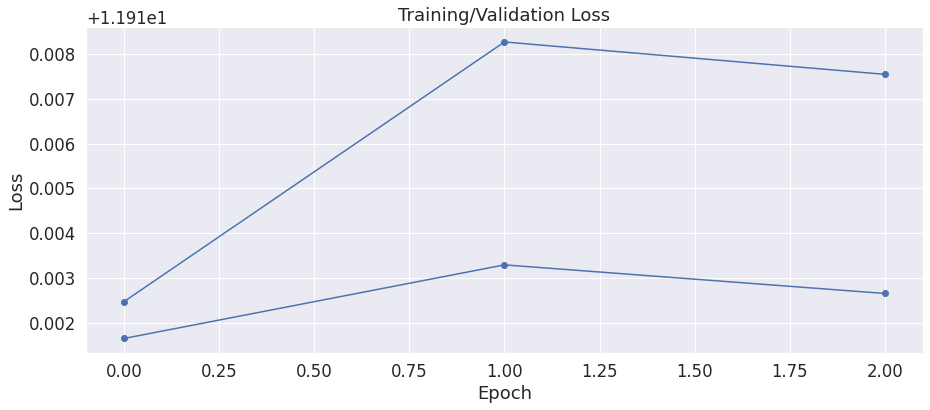

[2020-06-23 09:25:12,331][INFO] ## epoch: best, acc: 0.29555933, f1: 0.22904364, best_f1: 0.23005720

INFO:mylogger:epoch: best, acc: 0.29555933, f1: 0.22904364, best_f1: 0.23005720



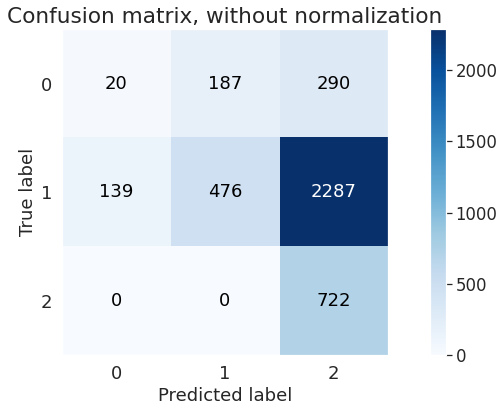

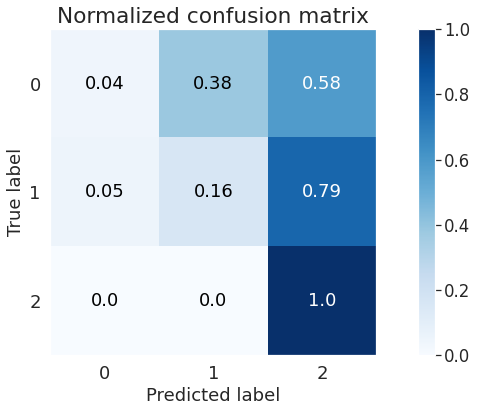

[2020-06-23 09:25:12,925][INFO] ## ================     fold 1        ===============
INFO:mylogger:================     fold 1        ===============
[2020-06-23 09:25:15,904][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


[2020-06-23 09:43:07,504][INFO] ## epoch: 0, train loss: 2.97636876, valid loss: 3.18188764, acc: 0.56927930, f1: 0.25088226, best_f1: 0.25088226

INFO:mylogger:epoch: 0, train loss: 2.97636876, valid loss: 3.18188764, acc: 0.56927930, f1: 0.25088226, best_f1: 0.25088226

[2020-06-23 09:43:08,186][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


[2020-06-23 10:00:54,160][INFO] ## epoch: 1, train loss: 2.98040258, valid loss: 3.17952951, acc: 0.56952196, f1: 0.25102947, best_f1: 0.25102947

INFO:mylogger:epoch: 1, train loss: 2.98040258, valid loss: 3.17952951, acc: 0.56952196, f1: 0.25102947, best_f1: 0.25102947

[2020-06-23 10:00:54,734][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


[2020-06-23 10:18:40,215][INFO] ## epoch: 2, train loss: 2.97538974, valid loss: 3.17885557, acc: 0.56927930, f1: 0.25084202, best_f1: 0.25102947

INFO:mylogger:epoch: 2, train loss: 2.97538974, valid loss: 3.17885557, acc: 0.56927930, f1: 0.25084202, best_f1: 0.25102947



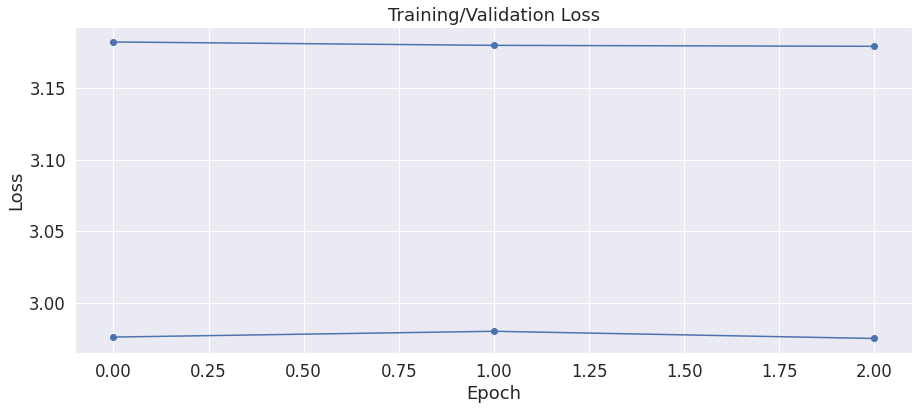

[2020-06-23 10:20:13,288][INFO] ## epoch: best, acc: 0.56903664, f1: 0.25101691, best_f1: 0.25102947

INFO:mylogger:epoch: best, acc: 0.56903664, f1: 0.25101691, best_f1: 0.25102947



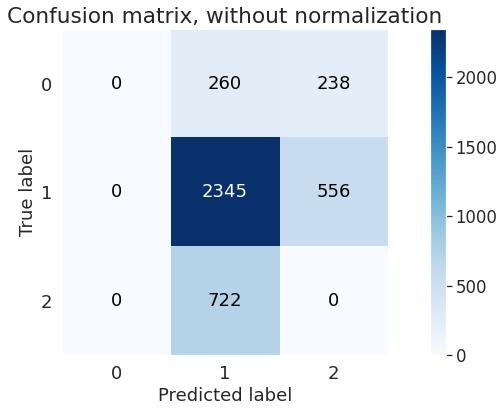

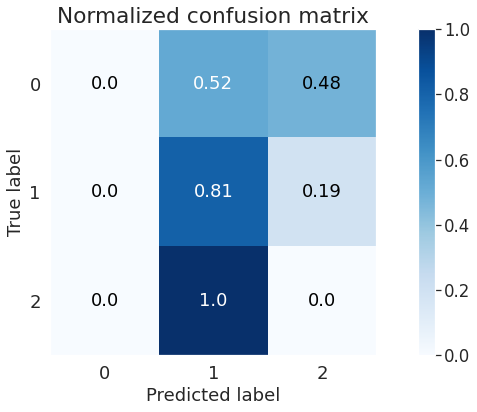

[2020-06-23 10:20:13,868][INFO] ## ================     fold 2        ===============
INFO:mylogger:================     fold 2        ===============
[2020-06-23 10:20:16,872][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


[2020-06-23 10:38:22,995][INFO] ## epoch: 0, train loss: 2.63538916, valid loss: 2.68948913, acc: 0.21232711, f1: 0.21173593, best_f1: 0.21173593

INFO:mylogger:epoch: 0, train loss: 2.63538916, valid loss: 2.68948913, acc: 0.21232711, f1: 0.21173593, best_f1: 0.21173593

[2020-06-23 10:38:23,677][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


[2020-06-23 10:56:16,628][INFO] ## epoch: 1, train loss: 2.63376638, valid loss: 2.69527933, acc: 0.21208445, f1: 0.21140942, best_f1: 0.21173593

INFO:mylogger:epoch: 1, train loss: 2.63376638, valid loss: 2.69527933, acc: 0.21208445, f1: 0.21140942, best_f1: 0.21173593



[2020-06-23 10:56:17,167][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


[2020-06-23 11:14:16,867][INFO] ## epoch: 2, train loss: 2.63409564, valid loss: 2.69337836, acc: 0.21354040, f1: 0.21546970, best_f1: 0.21546970

INFO:mylogger:epoch: 2, train loss: 2.63409564, valid loss: 2.69337836, acc: 0.21354040, f1: 0.21546970, best_f1: 0.21546970



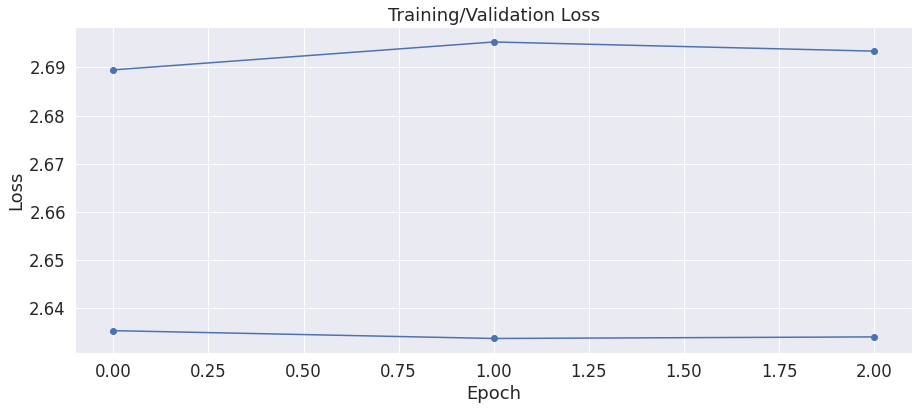

[2020-06-23 11:15:50,037][INFO] ## epoch: best, acc: 0.21184179, f1: 0.21112611, best_f1: 0.21546970

INFO:mylogger:epoch: best, acc: 0.21184179, f1: 0.21112611, best_f1: 0.21546970



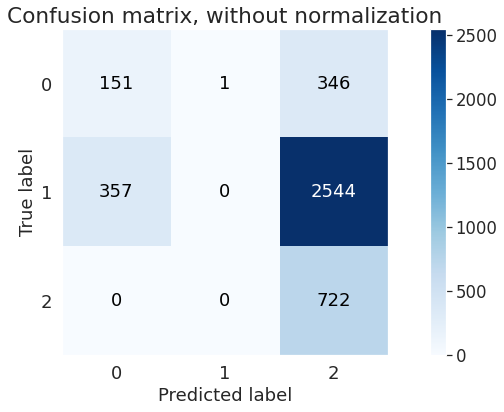

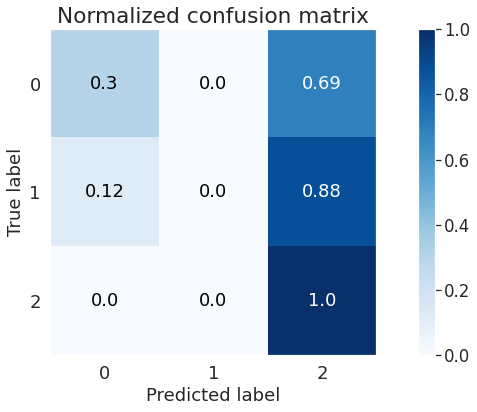

[2020-06-23 11:15:50,645][INFO] ## ================     fold 3        ===============
INFO:mylogger:================     fold 3        ===============
[2020-06-23 11:15:53,750][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


[2020-06-23 11:34:04,639][INFO] ## epoch: 0, train loss: 6.03274805, valid loss: 6.12056833, acc: 0.28609561, f1: 0.27935561, best_f1: 0.27935561

INFO:mylogger:epoch: 0, train loss: 6.03274805, valid loss: 6.12056833, acc: 0.28609561, f1: 0.27935561, best_f1: 0.27935561

[2020-06-23 11:34:05,317][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


[2020-06-23 11:52:05,730][INFO] ## epoch: 1, train loss: 6.02366861, valid loss: 6.11950239, acc: 0.28585295, f1: 0.27906436, best_f1: 0.27935561

INFO:mylogger:epoch: 1, train loss: 6.02366861, valid loss: 6.11950239, acc: 0.28585295, f1: 0.27906436, best_f1: 0.27935561

[2020-06-23 11:52:06,285][INFO] ## ================     epoch 3        ===============


INFO:mylogger:================     epoch 3        ===============


[2020-06-23 12:10:07,006][INFO] ## epoch: 2, train loss: 6.02608240, valid loss: 6.12041244, acc: 0.28585295, f1: 0.27914947, best_f1: 0.27935561

INFO:mylogger:epoch: 2, train loss: 6.02608240, valid loss: 6.12041244, acc: 0.28585295, f1: 0.27914947, best_f1: 0.27935561



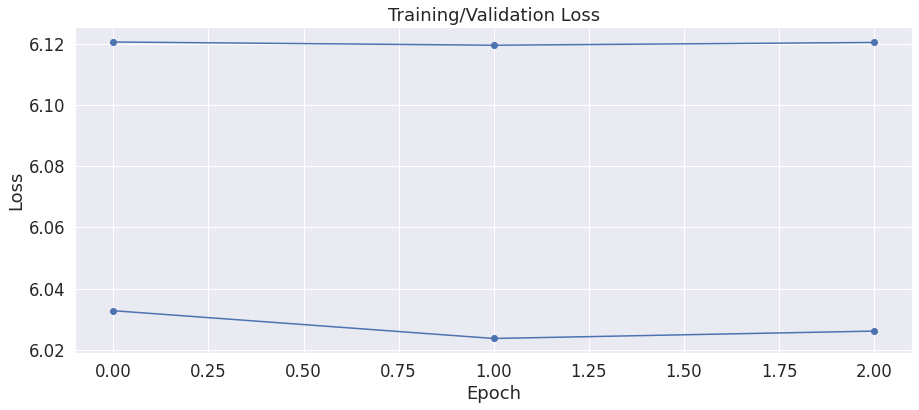

[2020-06-23 12:11:40,628][INFO] ## epoch: best, acc: 0.28366901, f1: 0.27636869, best_f1: 0.27935561

INFO:mylogger:epoch: best, acc: 0.28366901, f1: 0.27636869, best_f1: 0.27935561



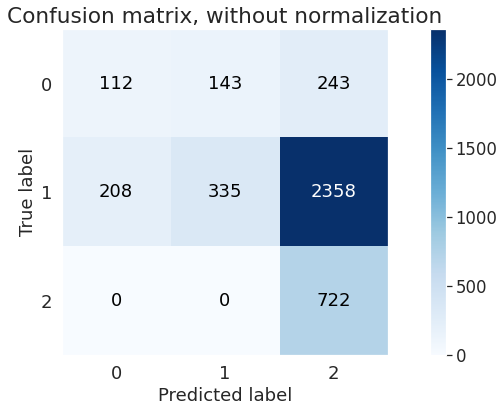

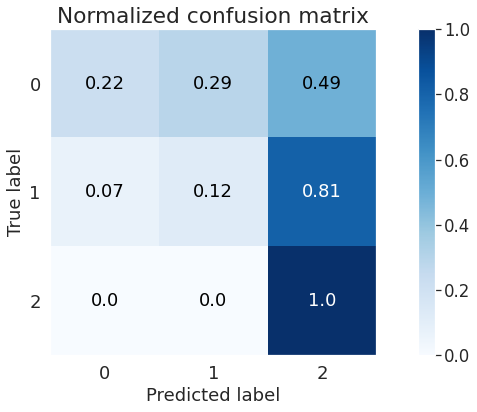

[2020-06-23 12:11:41,235][INFO] ## ================     fold 4        ===============
INFO:mylogger:================     fold 4        ===============
[2020-06-23 12:11:44,343][INFO] ## ================     epoch 1        ===============
INFO:mylogger:================     epoch 1        ===============


[2020-06-23 12:29:51,662][INFO] ## epoch: 0, train loss: 6.44890112, valid loss: 6.38036790, acc: 0.58699345, f1: 0.25360382, best_f1: 0.25360382

INFO:mylogger:epoch: 0, train loss: 6.44890112, valid loss: 6.38036790, acc: 0.58699345, f1: 0.25360382, best_f1: 0.25360382

[2020-06-23 12:29:52,354][INFO] ## ================     epoch 2        ===============
INFO:mylogger:================     epoch 2        ===============


[2020-06-23 12:47:52,020][INFO] ## epoch: 1, train loss: 6.42789592, valid loss: 6.37947460, acc: 0.58650813, f1: 0.25347386, best_f1: 0.25360382

INFO:mylogger:epoch: 1, train loss: 6.42789592, valid loss: 6.37947460, acc: 0.58650813, f1: 0.25347386, best_f1: 0.25360382



[2020-06-23 12:47:52,591][INFO] ## ================     epoch 3        ===============
INFO:mylogger:================     epoch 3        ===============


[2020-06-23 13:05:51,862][INFO] ## epoch: 2, train loss: 6.43622316, valid loss: 6.37983033, acc: 0.58650813, f1: 0.25347386, best_f1: 0.25360382

INFO:mylogger:epoch: 2, train loss: 6.43622316, valid loss: 6.37983033, acc: 0.58650813, f1: 0.25347386, best_f1: 0.25360382



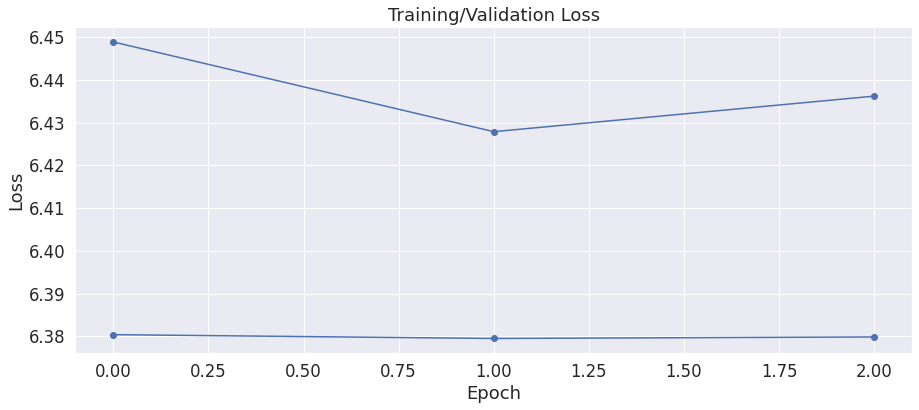

[2020-06-23 13:07:24,121][INFO] ## epoch: best, acc: 0.58626547, f1: 0.25340885, best_f1: 0.25360382

INFO:mylogger:epoch: best, acc: 0.58626547, f1: 0.25340885, best_f1: 0.25360382



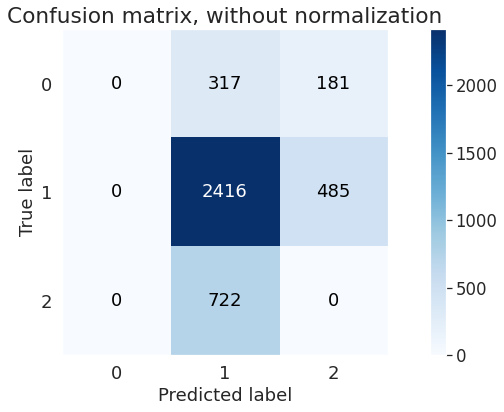

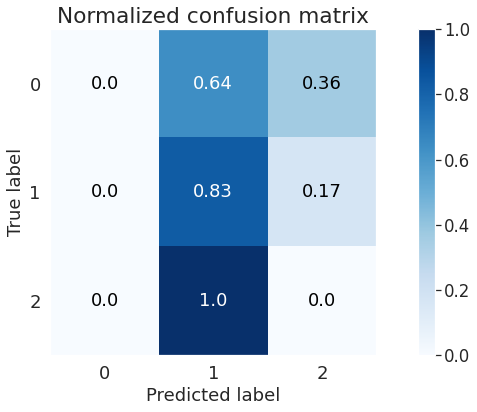

In [124]:
if use_skf:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  
    for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
        train_bert(fold, train_indices, valid_indices)

else:
    train_ratio = 0.7
    train_indices = np.arange(0, int(len(train_valid_labels)*train_ratio))
    valid_indices = np.arange(int(len(train_valid_labels)*train_ratio), len(train_valid_labels))

    train_bert(0, train_indices, valid_indices)
    # print('train_indices', train_indices)
    # print('valid_indices', valid_indices)


In [126]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))
split_train_df['pred_target'] = np.argmax(oof_train, axis=1)
split_train_df['pred_target_lower'] = oof_train[:,0]
split_train_df['pred_target_hold'] = oof_train[:,1]
split_train_df['pred_target_raise'] = oof_train[:,2]
split_train_df.head()

[2020-06-23 13:07:48,800][INFO] ## 0.31424289600202565
INFO:mylogger:0.31424289600202565


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,text,tone,token_ids,pred_target,pred_target_lower,pred_target_hold,pred_target_raise
0,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,The Secretary reported that advices of the ele...,-0.146711,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...",1,2.437155e-06,9.999976e-01,3.393402e-09
1,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,Manager of the System Open Market Account Depu...,-0.146711,"[55, 56, 11, 12, 57, 58, 55, 59, 60, 56, 11, 1...",2,2.104234e-06,5.912340e-12,9.999979e-01
2,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,the System Open Market Account that were conta...,-0.146711,"[56, 11, 12, 57, 103, 25, 77, 104, 105, 56, 11...",1,2.459453e-06,9.999975e-01,3.388551e-09
3,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,allow them to mature without replacement provi...,-0.146711,"[144, 142, 145, 146, 147, 148, 149, 118, 119, ...",2,2.124860e-07,1.767603e-06,9.999980e-01
4,1,1,1.043165,55.8,261.0,1.807631,0.0,-0.015902,14.901418,0.035879,to nine months at the time of acceptance that ...,-0.146711,"[175, 176, 177, 169, 178, 179, 180, 181, 182, ...",1,2.147684e-02,9.782692e-01,2.539838e-04


# Save Data

In [127]:
def save_data(df, file_name, dir_name=train_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [128]:
# Save text data
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')
save_data(train_df, 'split_train_df')